<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/RL_PPO_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  20 of 20 completed


PPO Episode 0 | Reward: 2.1404 | Critic Loss: 0.0040
PPO Episode 1 | Reward: 2.1380 | Critic Loss: 0.0037
PPO Episode 2 | Reward: 2.1361 | Critic Loss: 0.0037
PPO Episode 3 | Reward: 2.1349 | Critic Loss: 0.0036
PPO Episode 4 | Reward: 2.1338 | Critic Loss: 0.0035
PPO Episode 5 | Reward: 2.1330 | Critic Loss: 0.0035
PPO Episode 6 | Reward: 2.1330 | Critic Loss: 0.0035
PPO Episode 7 | Reward: 2.1336 | Critic Loss: 0.0035
PPO Episode 8 | Reward: 2.1348 | Critic Loss: 0.0034
PPO Episode 9 | Reward: 2.1356 | Critic Loss: 0.0034
PPO Episode 10 | Reward: 2.1362 | Critic Loss: 0.0034
PPO Episode 11 | Reward: 2.1371 | Critic Loss: 0.0034
PPO Episode 12 | Reward: 2.1378 | Critic Loss: 0.0034
PPO Episode 13 | Reward: 2.1384 | Critic Loss: 0.0034
PPO Episode 14 | Reward: 2.1389 | Critic Loss: 0.0034
PPO Episode 15 | Reward: 2.1391 | Critic Loss: 0.0034
PPO Episode 16 | Reward: 2.1395 | Critic Loss: 0.0034
PPO Episode 17 | Reward: 2.1401 | Critic Loss: 0.0034
PPO Episode 18 | Reward: 2.1405 | Crit

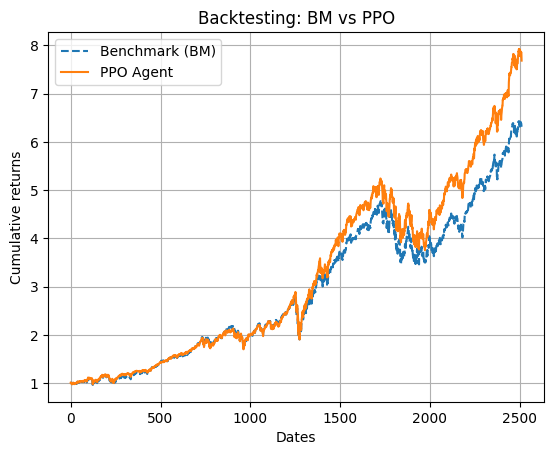

In [3]:
# PPO 포트 최적화
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정)"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)  # 확률 분포 변환

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        action = self.softmax(logits)  # 확률값 반환
        return action

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

    """
    actor.train() # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    # 전체 학습 과정 시작 (num_episodes 만큼 반복)
    for episode in range(num_episodes):
        states, actions, rewards, old_probs = [], [], [], []
        state = env.reset() # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False # 에피소드 종료 여부

        # (3) 하나의 에피소드 동안 반복 (환경이 종료될 때까지)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            # Actor 네트워크를 통해 행동(action) 예측 (포트폴리오 가중치)
            action = actor(state_tensor).squeeze(0)
            # 상태, 행동, 행동 확률(old_probs)을 저장 (나중에 업데이트에 활용)
            states.append(state)
            actions.append(action.detach().numpy())
            old_probs.append(action.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0 # 미래 보상의 누적 값
        for r in reversed(rewards):  # 보상을 역순으로 반복
            R = r + gamma * R
            returns.insert(0, R)  # 앞쪽에 삽입하여 정방향 순서로 저장
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        old_probs_tensor = torch.stack(old_probs)

        # (6) PPO 업데이트 (K_epochs 만큼 반복)
        for _ in range(K_epochs):
            # Critic 네트워크를 이용하여 현재 상태의 가치 예측
            values = critic(states_tensor).squeeze(1)  # [batch_size] 형태로 변환
            advantages = returns - values.detach() # 실제 리턴(returns) - 예측 가치(values)
            # Advantage를 정규화하여 안정적인 학습 유도
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Actor 네트워크에서 새로운 행동 확률 계산
            new_probs = actor(states_tensor)
            # PPO 손실 함수 계산
            # (7) 비율 계산: 새로운 정책의 행동 확률 / 기존 정책의 행동 확률
            ratio = (new_probs / old_probs_tensor).prod(dim=1) # .prod(dim=1)는 배열의 요소를 특정 차원(dim=1)을 따라 곱하는 연산으로 각 종목에 대한 개별 행동 확률 비율을 모두 곱해서 최종적인 행동 확률 비율을 만든다는 의미
            # (8) PPO 손실의 두 가지 항목 계산: clamp로 clipping 적용
            surr1 = ratio * advantages  # 기존 방식의 정책 개선 (Unclipped)
            surr2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages  # 클리핑 적용된 정책 개선 (Clipped)
            actor_loss = -torch.min(surr1, surr2).mean() # (9) PPO Actor 손실: 두 개의 손실 중 작은 값 선택 (Conservative Update)

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad() # (11) Actor 네트워크 업데이트
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad() # (12) Critic 네트워크 업데이트
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {sum(rewards):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor_model(state_tensor).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

plt.plot(benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

PPO Episode 0 | Reward: 2.1492 | Critic Loss: 0.0041
PPO Episode 1 | Reward: 2.1507 | Critic Loss: 0.0038
PPO Episode 2 | Reward: 2.1521 | Critic Loss: 0.0037
PPO Episode 3 | Reward: 2.1532 | Critic Loss: 0.0036
PPO Episode 4 | Reward: 2.1542 | Critic Loss: 0.0036
PPO Episode 5 | Reward: 2.1550 | Critic Loss: 0.0036
PPO Episode 6 | Reward: 2.1560 | Critic Loss: 0.0036
PPO Episode 7 | Reward: 2.1573 | Critic Loss: 0.0036
PPO Episode 8 | Reward: 2.1587 | Critic Loss: 0.0035
PPO Episode 9 | Reward: 2.1601 | Critic Loss: 0.0035
PPO Episode 10 | Reward: 2.1614 | Critic Loss: 0.0035
PPO Episode 11 | Reward: 2.1626 | Critic Loss: 0.0035
PPO Episode 12 | Reward: 2.1636 | Critic Loss: 0.0035
PPO Episode 13 | Reward: 2.1644 | Critic Loss: 0.0034
PPO Episode 14 | Reward: 2.1651 | Critic Loss: 0.0034
PPO Episode 15 | Reward: 2.1659 | Critic Loss: 0.0034
PPO Episode 16 | Reward: 2.1670 | Critic Loss: 0.0034
PPO Episode 17 | Reward: 2.1676 | Critic Loss: 0.0034
PPO Episode 18 | Reward: 2.1684 | Crit

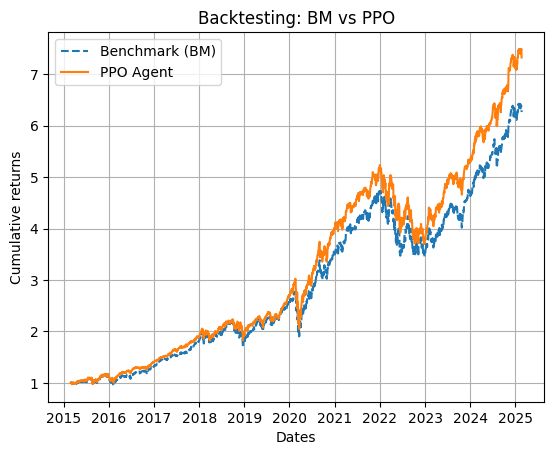

In [6]:
# 위 코드에서 plotting할 때, 날짜 카운트가 아닌 연도별로 표시되도록 바꿨다.
# (맨 밑에 plt 부분만 수정함)
# PPO 포트 최적화
"""
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()
"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정)"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)  # 확률 분포 변환

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        action = self.softmax(logits)  # 확률값 반환
        return action

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

    """
    actor.train() # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    # 전체 학습 과정 시작 (num_episodes 만큼 반복)
    for episode in range(num_episodes):
        states, actions, rewards, old_probs = [], [], [], []
        state = env.reset() # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False # 에피소드 종료 여부

        # (3) 하나의 에피소드 동안 반복 (환경이 종료될 때까지)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            # Actor 네트워크를 통해 행동(action) 예측 (포트폴리오 가중치)
            action = actor(state_tensor).squeeze(0)
            # 상태, 행동, 행동 확률(old_probs)을 저장 (나중에 업데이트에 활용)
            states.append(state)
            actions.append(action.detach().numpy())
            old_probs.append(action.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0 # 미래 보상의 누적 값
        for r in reversed(rewards):  # 보상을 역순으로 반복
            R = r + gamma * R
            returns.insert(0, R)  # 앞쪽에 삽입하여 정방향 순서로 저장
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        old_probs_tensor = torch.stack(old_probs)

        # (6) PPO 업데이트 (K_epochs 만큼 반복)
        for _ in range(K_epochs):
            # Critic 네트워크를 이용하여 현재 상태의 가치 예측
            values = critic(states_tensor).squeeze(1)  # [batch_size] 형태로 변환
            advantages = returns - values.detach() # 실제 리턴(returns) - 예측 가치(values)
            # Advantage를 정규화하여 안정적인 학습 유도
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Actor 네트워크에서 새로운 행동 확률 계산
            new_probs = actor(states_tensor)
            # PPO 손실 함수 계산
            # (7) 비율 계산: 새로운 정책의 행동 확률 / 기존 정책의 행동 확률
            ratio = (new_probs / old_probs_tensor).prod(dim=1) # .prod(dim=1)는 배열의 요소를 특정 차원(dim=1)을 따라 곱하는 연산으로 각 종목에 대한 개별 행동 확률 비율을 모두 곱해서 최종적인 행동 확률 비율을 만든다는 의미
            # (8) PPO 손실의 두 가지 항목 계산: clamp로 clipping 적용
            surr1 = ratio * advantages  # 기존 방식의 정책 개선 (Unclipped)
            surr2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages  # 클리핑 적용된 정책 개선 (Clipped)
            actor_loss = -torch.min(surr1, surr2).mean() # (9) PPO Actor 손실: 두 개의 손실 중 작은 값 선택 (Conservative Update)

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad() # (11) Actor 네트워크 업데이트
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad() # (12) Critic 네트워크 업데이트
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {sum(rewards):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor_model(state_tensor).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]

plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

PPO Episode 0 | Reward: 2.1627 | Critic Loss: 0.0045
PPO Episode 1 | Reward: 2.1629 | Critic Loss: 0.0038
PPO Episode 2 | Reward: 2.1630 | Critic Loss: 0.0037
PPO Episode 3 | Reward: 2.1632 | Critic Loss: 0.0037
PPO Episode 4 | Reward: 2.1633 | Critic Loss: 0.0037
PPO Episode 5 | Reward: 2.1630 | Critic Loss: 0.0036
PPO Episode 6 | Reward: 2.1635 | Critic Loss: 0.0036
PPO Episode 7 | Reward: 2.1640 | Critic Loss: 0.0036
PPO Episode 8 | Reward: 2.1640 | Critic Loss: 0.0035
PPO Episode 9 | Reward: 2.1637 | Critic Loss: 0.0035
PPO Episode 10 | Reward: 2.1637 | Critic Loss: 0.0035
PPO Episode 11 | Reward: 2.1638 | Critic Loss: 0.0035
PPO Episode 12 | Reward: 2.1640 | Critic Loss: 0.0034
PPO Episode 13 | Reward: 2.1641 | Critic Loss: 0.0034
PPO Episode 14 | Reward: 2.1640 | Critic Loss: 0.0034
PPO Episode 15 | Reward: 2.1641 | Critic Loss: 0.0034
PPO Episode 16 | Reward: 2.1644 | Critic Loss: 0.0034
PPO Episode 17 | Reward: 2.1645 | Critic Loss: 0.0034
PPO Episode 18 | Reward: 2.1647 | Crit

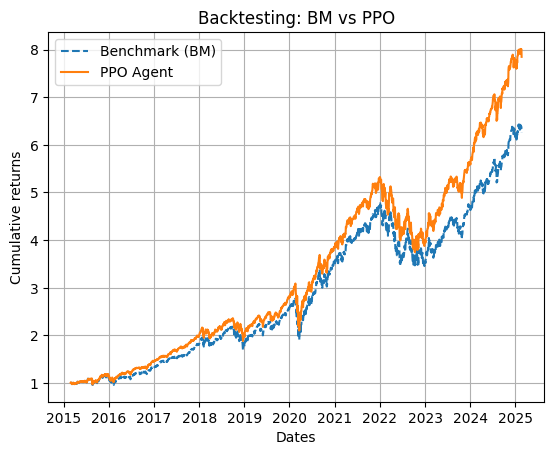

In [7]:
# 위 코드에서 plotting할 때, 날짜 카운트가 아닌 연도별로 표시되도록 바꿨다.
# (맨 밑에 plt 부분만 수정함)
# PPO 포트 최적화
"""
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()
"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정)"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)  # 확률 분포 변환

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        action = self.softmax(logits)  # 확률값 반환
        return action

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

    """
    actor.train() # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    # 전체 학습 과정 시작 (num_episodes 만큼 반복)
    for episode in range(num_episodes):
        states, actions, rewards, old_probs = [], [], [], []
        state = env.reset() # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False # 에피소드 종료 여부

        # (3) 하나의 에피소드 동안 반복 (환경이 종료될 때까지)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            # Actor 네트워크를 통해 행동(action) 예측 (포트폴리오 가중치)
            action = actor(state_tensor).squeeze(0)
            # 상태, 행동, 행동 확률(old_probs)을 저장 (나중에 업데이트에 활용)
            states.append(state)
            actions.append(action.detach().numpy())
            old_probs.append(action.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0 # 미래 보상의 누적 값
        for r in reversed(rewards):  # 보상을 역순으로 반복
            R = r + gamma * R
            returns.insert(0, R)  # 앞쪽에 삽입하여 정방향 순서로 저장
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        old_probs_tensor = torch.stack(old_probs)

        # (6) PPO 업데이트 (K_epochs 만큼 반복)
        for _ in range(K_epochs):
            # Critic 네트워크를 이용하여 현재 상태의 가치 예측
            values = critic(states_tensor).squeeze(1)  # [batch_size] 형태로 변환
            advantages = returns - values.detach() # 실제 리턴(returns) - 예측 가치(values)
            # Advantage를 정규화하여 안정적인 학습 유도
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Actor 네트워크에서 새로운 행동 확률 계산
            new_probs = actor(states_tensor)
            # PPO 손실 함수 계산
            # (7) 비율 계산: 새로운 정책의 행동 확률 / 기존 정책의 행동 확률
            ratio = (new_probs / old_probs_tensor).prod(dim=1) # .prod(dim=1)는 배열의 요소를 특정 차원(dim=1)을 따라 곱하는 연산으로 각 종목에 대한 개별 행동 확률 비율을 모두 곱해서 최종적인 행동 확률 비율을 만든다는 의미
            # (8) PPO 손실의 두 가지 항목 계산: clamp로 clipping 적용
            surr1 = ratio * advantages  # 기존 방식의 정책 개선 (Unclipped)
            surr2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages  # 클리핑 적용된 정책 개선 (Clipped)
            actor_loss = -torch.min(surr1, surr2).mean() # (9) PPO Actor 손실: 두 개의 손실 중 작은 값 선택 (Conservative Update)

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad() # (11) Actor 네트워크 업데이트
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad() # (12) Critic 네트워크 업데이트
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {sum(rewards):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor_model(state_tensor).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]

plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

첫 질문-첫 답변에서 제시해준 단점 및 부족한 점 중에서
1) Softmax를 이용해 포트폴리오 비중을 산출하는 방식은 간단하지만, 탐색(exploration)을 위한 확률적 샘플링과 entropy 보너스가 포함되지 않아 학습 초반이나 지역 최적해에 빠질 위험이 있다고 한 부분을 개선해줘. 즉 softmax 대신 dirichlet 분포를 사용하고, 행동 확률의 비율을 계산할 때 로그 확률을 사용하고, 차이를 지수화하여 계산하면 수치적 안정성을 높일 수 있게 수정해줘. 추가로, 탐색을 유도하기 위해 정책 손실에 entropy 항을 추가해 학습 초반 다양한 행동을 시도하도록 유도할 수 있도록 수정해줘.

그리고 PPO 업데이트 시 new_probs / old_probs의 ratio를 계산할 때, 일반적으로는 로그 확률 차이를 활용해 비율을 계산하는 방법이 더 안정적이라고 한 부분을 반영해줘.

모든 요구사항을 반영해서 코드를 수정하고, 수정된 부분만 알려줘.

In [ ]:
# 위 코드에서 Softmax 대신 Dirichlet 분포 사용”, “로그 확률로 ratio 계산”, 
# “정책 손실에 엔트로피 항 추가했다.
# PPO 포트 최적화
"""
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()
"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Softmax 대신 Dirichlet 분포 사용
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정) - Dirichlet 분포 기반"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()  # alpha 값이 양수가 되도록

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Dirichlet 분포의 파라미터(alpha > 0)를 위해 softplus 적용 후 작은 상수 추가
        alpha = self.softplus(self.fc3(x)) + 1e-6  
        dist = torch.distributions.Dirichlet(alpha)
        return dist

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
entropy_coef = 0.01   # [수정됨] 엔트로피 보너스 계수

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
    """
    actor.train()  # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []  # [수정됨] 기존 행동의 로그 확률 저장 리스트
        state = env.reset()  # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False

        # 에피소드 진행 (Trajectory 수집)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist = actor(state_tensor)           # [수정됨] Dirichlet 분포 객체 반환
            action = dist.sample()               # [수정됨] 분포에서 샘플링
            log_prob = dist.log_prob(action)     # [수정됨] 로그 확률 계산

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상(Return) 계산
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        # [수정됨] 텐서 변환
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # PPO 업데이트 (K_epochs 반복)
        for _ in range(K_epochs):
            values = critic(states_tensor).squeeze(1)  # Critic 예측
            advantages = returns - values.detach()
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            dist = actor(states_tensor)  # 새로운 분포 계산
            new_log_probs = dist.log_prob(actions_tensor)
            # [수정됨] 로그 확률 차이를 이용한 ratio 계산
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            # [수정됨] 엔트로피 보너스 추가 (탐색 유도)
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(알파/합) 사용하여 결정론적 행동 선택
            dist = actor_model(state_tensor)
            action = (dist.alpha / dist.alpha.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]
# 연도별로 X축 레이블을 표시하도록 설정
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

첫 질문-첫 답변에서 제시해준 단점 및 부족한 점 중에서

Advantage 계산 방식: 단순히 discounted reward와 Critic의 예측 차이를 사용하고 있으며, 분산을 줄이기 위한 Generalized Advantage Estimation (GAE) 기법을 도입하고 코드를 수정해줘.

모든 요구사항을 반영해서 코드를 수정하고, 수정된 부분만 알려줘.

In [ ]:
# 위 코드에서 advantage 계산할 때, VAE 로 대체한 코드
# PPO 포트 최적화
"""
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()
"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Softmax 대신 Dirichlet 분포 사용
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정) - Dirichlet 분포 기반"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()  # alpha 값이 양수가 되도록

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Dirichlet 분포의 파라미터(alpha > 0)를 위해 softplus 적용 후 작은 상수 추가
        alpha = self.softplus(self.fc3(x)) + 1e-6  
        dist = torch.distributions.Dirichlet(alpha)
        return dist

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
entropy_coef = 0.01   # [수정됨] 엔트로피 보너스 계수

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
    """
    actor.train()  # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []  # [수정됨] 기존 행동의 로그 확률 저장 리스트
        state = env.reset()  # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False

        # 에피소드 진행 (Trajectory 수집)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist = actor(state_tensor)           # [수정됨] Dirichlet 분포 객체 반환
            action = dist.sample()               # [수정됨] 분포에서 샘플링
            log_prob = dist.log_prob(action)     # [수정됨] 로그 확률 계산

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상(Return) 계산
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        # [수정됨] 텐서 변환
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # PPO 업데이트 (K_epochs 반복)
        for _ in range(K_epochs):
            values = critic(states_tensor).squeeze(1)  # Critic 예측
            advantages = returns - values.detach()
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            dist = actor(states_tensor)  # 새로운 분포 계산
            new_log_probs = dist.log_prob(actions_tensor)
            # [수정됨] 로그 확률 차이를 이용한 ratio 계산
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            # [수정됨] 엔트로피 보너스 추가 (탐색 유도)
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(알파/합) 사용하여 결정론적 행동 선택
            dist = actor_model(state_tensor)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()


        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]
# 연도별로 X축 레이블을 표시하도록 설정
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()